## Project Name: Song Recommendation System

Summary: in this project, we ask users to enter the name of their favorite song, if it's a hot song existing in our dataset(webscreaped from Billboard & Officialcharts), recommend another hot song othrwise, use machine learning to recommend a similar song from Spotify.


The project is consist of following steps:
- Collecting hot song informations from billboard.com and officialcharts.com using webscraping techniques
- Using Spotify's public API to collect song and playlist IDs
- Clustering songs based on their audio features
- Finding optimal number of KMeans clusters using Elbow method and Silhouette score

![Project's outline](./song-recommendation.png)

In [1]:
from IPython.display import IFrame
from bs4 import BeautifulSoup
import requests
import pprint
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np

from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle

In [2]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

/Users/hana/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Collecting Song Information from Spotify

In [3]:
#Initialize SpotiPy with user credentials (Make sure you create the config file using your own credentials)
sp = spotipy.Spotify(
    auth_manager = SpotifyClientCredentials(
        client_id = config.client_id,
        client_secret = config.client_secret)
)

In [4]:
# Add or remove Spotify playlist's name 
playlists = ['Latin','R&B', 'Love','Anime', 'Trending','Jazz', 'Metal', 'Party', 'Focus', 'Chill', 'Mood', 'Pop']

In [5]:
# Extract playlist IDs using playlist names
def get_playlist_ids(playlists):
    
    ids = []
    def get_playlist_id(playlist):
        pl = sp.search(playlist, type="playlist")
        pl_id = pl["playlists"]["items"][0]["id"]
        return pl_id

    for playlist in playlists:
        ids.append(get_playlist_id(playlist))

    return ids

In [6]:
# Use playlist IDs to extract the list of tracks in each playlist
def get_playlist_tracks(username, playlist_id):
    
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    return tracks

In [7]:
# Extract audio features of each track as a DataFrame
def get_df_for_playlist(username, playlist_id):
    
    # Get playlist tracks
    playlist_tracks = get_playlist_tracks(username, playlist_id)

    # Extract track IDs
    track_ids = [track['track']['id'] for track in playlist_tracks]
    
    chunk_size = 100
    track_ids_chopped = [track_ids[i:i+chunk_size] for i in range(0,len(track_ids),chunk_size)]
    # Get audio features

    af_list = []
    for chunk in track_ids_chopped:
        af_list.extend(sp.audio_features(chunk))
        
    af_df = pd.DataFrame(af_list)
   

    return af_df

In [8]:
playlist_ids = get_playlist_ids(playlists)
playlist_ids

['37i9dQZF1EQmK1rjZuPGDt',
 '37i9dQZF1EQoqCH7BwIYb7',
 '0whWWNcAlFitbHMFFUIIyp',
 '1YA5cPIfDy3L03bGnNiDM7',
 '5JNNpb0q7ZIM3s3j355Anr',
 '37i9dQZF1DXbITWG1ZJKYt',
 '37i9dQZF1EQpgT26jgbgRI',
 '5xS3Gi0fA3Uo6RScucyct6',
 '37i9dQZF1DWZeKCadgRdKQ',
 '37i9dQZF1EVHGWrwldPRtj',
 '37i9dQZF1EVKuMoAJjoTIw',
 '37i9dQZF1EQncLwOalG3K7']

In [19]:
# Create Dataframe for all audio fetures from spotify playlists
final_df = pd.DataFrame()

for playlist_id in playlist_ids:
    audio_feature_df = get_df_for_playlist("Spotify", playlist_id)
    final_df = pd.concat([final_df, audio_feature_df], ignore_index=True)

final_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.720,0.880,9,-2.834,1,0.1010,0.0562,0.06,0.153,0.463,180.011,audio_features,05WVKTdZhlIMX4qqMLuo0f,spotify:track:05WVKTdZhlIMX4qqMLuo0f,https://api.spotify.com/v1/tracks/05WVKTdZhlIM...,https://api.spotify.com/v1/audio-analysis/05WV...,197333,4
1,0.778,0.824,10,-5.892,0,0.0707,0.2840,0.00,0.405,0.758,100.024,audio_features,3ZFTkvIE7kyPt6Nu3PEa7V,spotify:track:3ZFTkvIE7kyPt6Nu3PEa7V,https://api.spotify.com/v1/tracks/3ZFTkvIE7kyP...,https://api.spotify.com/v1/audio-analysis/3ZFT...,218093,4
2,0.537,0.421,5,-8.720,1,0.0285,0.8270,0.00,0.138,0.524,98.224,audio_features,2HafqoJbgXdtjwCOvNEF14,spotify:track:2HafqoJbgXdtjwCOvNEF14,https://api.spotify.com/v1/tracks/2HafqoJbgXdt...,https://api.spotify.com/v1/audio-analysis/2Haf...,184061,4


In [20]:
final_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,0.568451,0.489176,5.121377,-10.650116,0.528986,0.066274,0.462680,0.256160,0.158821,0.410509,115.293034,224069.538043,3.916667
std,0.159967,0.311242,3.602877,6.656279,0.499385,0.061170,0.394083,0.380247,0.114231,0.248049,30.291425,89388.246903,0.390659
min,0.096700,0.007560,0.000000,-33.594000,0.000000,0.023900,0.000004,0.000000,0.023200,0.032300,35.366000,82125.000000,1.000000
25%,0.462000,0.182000,2.000000,-16.408250,0.000000,0.035475,0.043625,0.000000,0.097800,0.186500,93.288250,167445.500000,4.000000
50%,0.579000,0.511000,5.000000,-8.470000,1.000000,0.044750,0.415500,0.000447,0.113000,0.391000,116.714000,206157.000000,4.000000
75%,0.691000,0.783000,8.000000,-4.911750,1.000000,0.066000,0.884000,0.728500,0.178250,0.611250,131.949500,253211.000000,4.000000
max,0.967000,0.996000,11.000000,1.078000,1.000000,0.530000,0.995000,0.970000,0.979000,0.969000,219.483000,824133.000000,5.000000


##### Data Cleaning

In [21]:
# Drop duplicated rows
final_df = final_df.drop_duplicates()

### Using KMeans algorithm to cluster songs based on their audio features

In [26]:
# Select numerical columns and ID column to Scale
columns_to_drop = ['type', 'uri', 'track_href', 'analysis_url']
numerical_df = final_df.drop(columns=columns_to_drop).copy()


In [27]:
numerical_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.720,0.880,9,-2.834,1,0.1010,0.0562,0.06,0.153,0.463,180.011,05WVKTdZhlIMX4qqMLuo0f,197333,4
1,0.778,0.824,10,-5.892,0,0.0707,0.2840,0.00,0.405,0.758,100.024,3ZFTkvIE7kyPt6Nu3PEa7V,218093,4
2,0.537,0.421,5,-8.720,1,0.0285,0.8270,0.00,0.138,0.524,98.224,2HafqoJbgXdtjwCOvNEF14,184061,4


In [30]:
X = numerical_df.drop(columns="id",axis=1)

##### Scaling with StandardScaler

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X_scaled_df.head(3))

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.962736,1.261445,1.078425,1.189956,0.944150,0.556763,-1.048283,-0.527387,-0.057178,0.224711,2.120525,-0.298043,0.214062
1,1.325100,1.082219,1.355800,0.731257,-1.059154,0.065016,-0.469954,-0.684288,2.141703,1.418122,-0.499247,-0.067977,0.214062
2,-0.180584,-0.207565,-0.031076,0.307058,0.944150,-0.619858,0.908592,-0.684288,-0.188063,0.471484,-0.558201,-0.445125,0.214062


In [34]:
X_scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1080.000000,1.080000e+03,1.080000e+03,1.080000e+03,1080.000000,1080.000000
mean,5.921189e-17,2.368476e-16,-9.868649e-17,-1.315820e-16,4.605370e-17,-1.578984e-16,1.578984e-16,0.000000,-1.250029e-16,-2.631640e-17,5.921189e-17,0.000000,0.000000
std,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463,1.000463e+00,1.000463e+00,1.000463e+00,1.000463,1.000463
min,-2.931427e+00,-1.530761e+00,-1.417953e+00,-3.424033e+00,-1.059154e+00,-6.945128e-01,-1.190951e+00,-0.684288,-1.189776e+00,-1.517668e+00,-2.616956e+00,-1.574794,-7.407485
25%,-6.616538e-01,-9.860754e-01,-8.632024e-01,-8.662393e-01,-1.059154e+00,-5.030076e-01,-1.077859e+00,-0.684288,-5.373103e-01,-9.130739e-01,-7.283010e-01,-0.639375,0.214062
50%,6.619795e-02,1.966784e-02,-3.107631e-02,3.261078e-01,9.441497e-01,-3.545100e-01,-7.009923e-02,-0.682249,-3.974806e-01,-8.072076e-02,4.601643e-02,-0.202254,0.214062
75%,7.565638e-01,9.510005e-01,8.010497e-01,8.592441e-01,9.441497e-01,-7.609716e-03,1.069168e+00,1.309006,1.718724e-01,8.082688e-01,5.560706e-01,0.321205,0.214062
max,2.505907e+00,1.632698e+00,1.633176e+00,1.776754e+00,9.441497e-01,7.519111e+00,1.335103e+00,1.852275,7.150264e+00,2.271713e+00,3.413330e+00,6.648245,2.754577


##### Setting a predefined random state for the creation of 3 clusters

In [35]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=1234)

kmeans.fit(X_scaled)

/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=1234)

In [36]:
#Assigning labels to our clusters
labels = kmeans.labels_
labels

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [37]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

In [38]:
#Predicting clusters for our observations
clusters = kmeans.predict(X_scaled_df)

/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [39]:
#Examining the distribution of observations across each cluster.
pd.Series(clusters).value_counts().sort_index()

0    269
1    533
2    278
Name: count, dtype: int64

In [40]:
clusters

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [42]:
#Generated a 'clusters' column in the dataframe (df), partitioned the dataframe into three clusters, and assigned corresponding labels
X['clusters'] = clusters
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,0.720,0.880,9,-2.834,1,0.1010,0.0562,0.060000,0.153,0.463,180.011,197333,4,1
1,0.778,0.824,10,-5.892,0,0.0707,0.2840,0.000000,0.405,0.758,100.024,218093,4,1
2,0.537,0.421,5,-8.720,1,0.0285,0.8270,0.000000,0.138,0.524,98.224,184061,4,0
3,0.911,0.778,5,-2.248,1,0.2620,0.0887,0.000022,0.179,0.345,96.057,162768,4,1
4,0.800,0.738,7,-4.260,1,0.0691,0.3720,0.008770,0.190,0.267,103.008,174230,4,1


In [43]:
#Acquiring a sample to evaluate the model
X[X['clusters']==2].sample()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
881,0.313,0.101,1,-12.962,0,0.0662,0.966,0.898,0.107,0.0693,177.785,209326,4,2


In [44]:
#calculating the inertia or sum of distances of each observation from their centroid of cluster
kmeans.inertia_

9449.14862472408

## Finding optimal number of KMeans clusters using Elbow method and Silhouette score

In [45]:
kmeans2 = KMeans(n_clusters=3,
                init="k-means++",
                n_init=10,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=5,
                algorithm="elkan",
                random_state=1234)
kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

9450.578456823478


##### Using the Elbow Method and showing the optimal k

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 



/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 



/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 



/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 



/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

Training a K-Means model with 20 clusters! 



/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

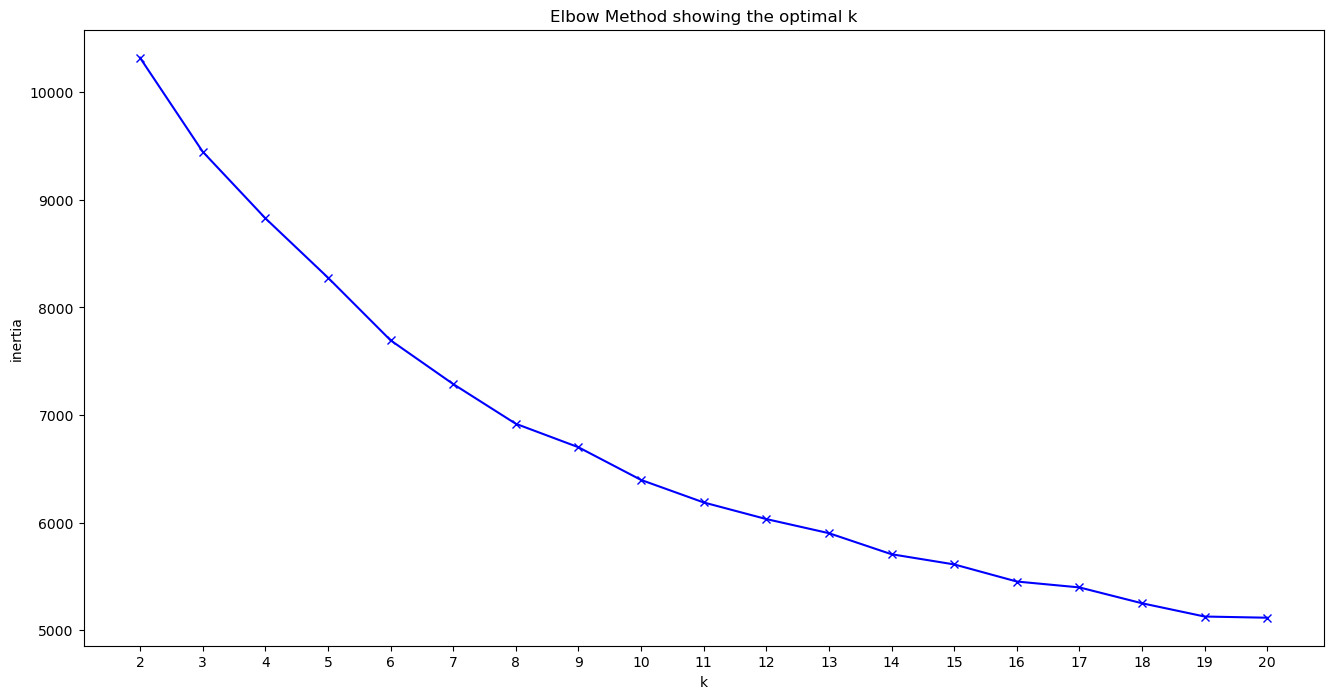

In [46]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

##### Using the Silhouette Method showing the optimal k

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

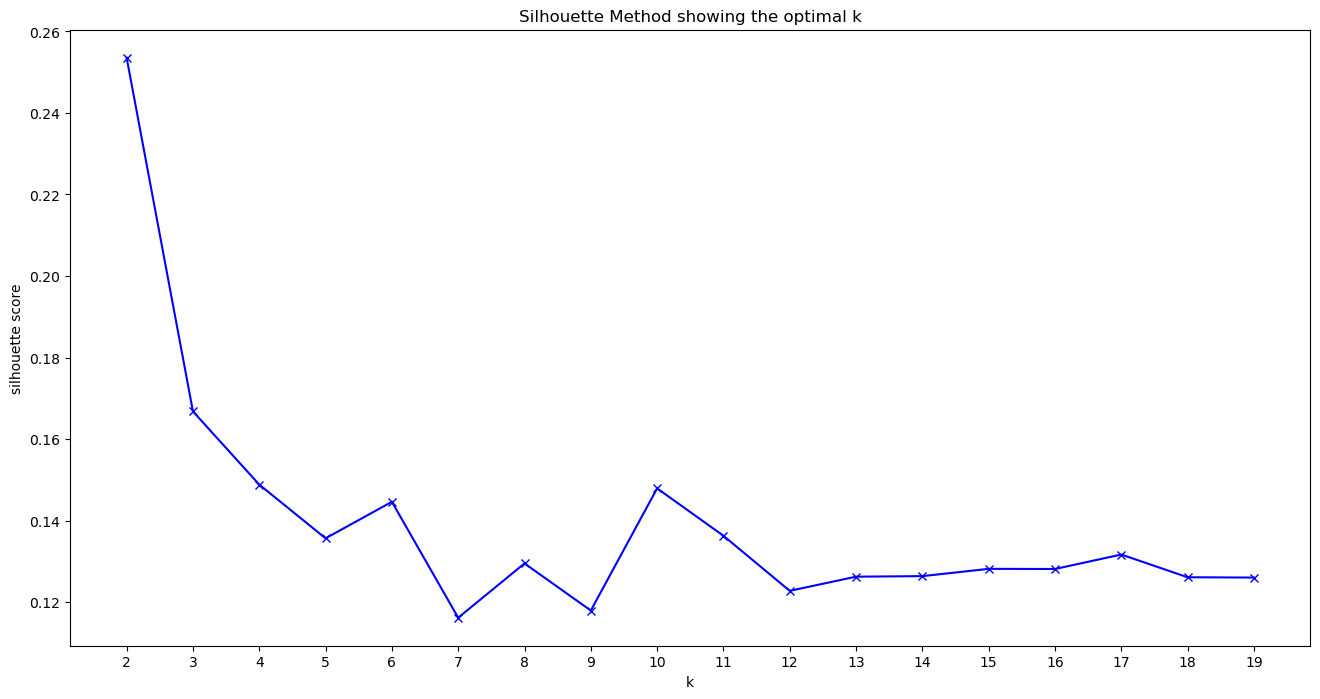

In [47]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(X_scaled_df)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [48]:
#Selecting 12 clusters using the elbow method and silhouette method, considering the number of playlists

n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=1234)

kmeans.fit(X_scaled)

/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=1234)

In [49]:
#Labeling the clusters
labels = kmeans.labels_
labels

array([ 4,  8, 10, ...,  8,  4,  0], dtype=int32)

In [50]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [51]:
#Predicting the number of clusters for our observations
clusters = kmeans.predict(X_scaled_df)

/Users/hana/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [52]:
#Assessing the distribution of observations in each cluster
pd.Series(clusters).value_counts().sort_index()

0     157
1     130
2     147
3      21
4      81
5      75
6       9
7     103
8     104
9      61
10    142
11     50
Name: count, dtype: int64

In [53]:
clusters

array([ 4,  8, 10, ...,  8,  4,  0], dtype=int32)

In [55]:
#Generated a 'clusters' column in the dataframe (df), partitioned the dataframe into three clusters, and assigned corresponding labels
X['clusters'] = clusters
X.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,0.720,0.880,9,-2.834,1,0.1010,0.0562,0.06,0.153,0.463,180.011,197333,4,4
1,0.778,0.824,10,-5.892,0,0.0707,0.2840,0.00,0.405,0.758,100.024,218093,4,8
2,0.537,0.421,5,-8.720,1,0.0285,0.8270,0.00,0.138,0.524,98.224,184061,4,10


In [56]:
#Acquiring a sample to evaluate the model
X[X['clusters']==2].sample()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
722,0.668,0.758,7,-3.589,1,0.158,0.0338,0.0,0.204,0.531,135.958,229507,4,2


In [57]:
#calculating the inertia or sum of distances of each observation from their centroid of cluster
kmeans.inertia_

6032.33463068916

In [58]:
#Saving the trained model using pickle, and dumping the model into pickle files
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("kmeans_4.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [59]:
#Loading the pickle
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

In [60]:
scaler= load(filename="scaler.pickle")

In [61]:
kmeans_model = load(filename="kmeans_4.pickle")
kmeans_model

KMeans(n_clusters=12, random_state=1234)

In [62]:
scaler2 = load("scaler.pickle")

## Collecting hot song informations from billboard.com and officialcharts.com using webscraping techniques

In [63]:
# 2.Locating URL and Assigning to Variable
# 3.Downloading HTML with a GET Request 

url = 'https://www.billboard.com/charts/hot-100/'
response = requests.get(url)
soup = BeautifulSoup(response.content)
hiss = soup.select('h3.c-title.a-font-primary-bold-l')

In [64]:
soup.select('li.o-chart-results-list__item h3.c-title')

[<h3 class="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet" id="title-of-a-story">
 
 	
 	
 		
 					Lovin On Me		
 	
 </h3>,
 <h3 class="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only" id="title-of-a-story">
 
 	
 	
 		
 					Texas Hold 'Em		
 	
 </h3>,
 <h3 class="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only" id="title-of-a-story">
 
 	
 	
 		
 					Carnival		
 	
 </h3>,
 <h3 class="c-title a-no-trucate a-font-primary-bold-s u-letter-sp

In [65]:
#reating a list of the best songs 
songs = []
for song in soup.select('li.o-chart-results-list__item h3.c-title#title-of-a-story'):
    title = song.get_text().strip()
    songs.append(title)
songs

['Lovin On Me',
 "Texas Hold 'Em",
 'Carnival',
 'Beautiful Things',
 'Lose Control',
 'Cruel Summer',
 'Snooze',
 'I Remember Everything',
 'Greedy',
 'Stick Season',
 'Fast Car',
 'Agora Hills',
 'Water',
 'Last Night',
 'Redrum',
 "Thinkin' Bout Me",
 'Flowers',
 "Is It Over Now? (Taylor's Version) [From The Vault]",
 'Paint The Town Red',
 'Yeah!',
 'Never Lose Me',
 'La Diabla',
 'Fuk Sumn',
 'Pretty Little Poison',
 'Houdini',
 'Back To Me',
 'What Was I Made For?',
 'Forever',
 'Where The Wild Things Are',
 'Talking',
 'Yes, And?',
 'Made For Me',
 'Burn',
 'Vultures',
 'The Painter',
 'Good Good',
 'Selfish',
 '16 Carriages',
 'Stars',
 'Everybody',
 'Rich Baby Daddy',
 'Feather',
 'Vampire',
 'On My Mama',
 'Wild Ones',
 'Dance The Night',
 'Save Me',
 'Hiss',
 'Exes',
 'Need A Favor',
 'Truck Bed',
 'Do It',
 'Paid',
 'Surround Sound',
 'Keys To My Life',
 'World On Fire',
 'First Person Shooter',
 'La Victima',
 'Get In With Me',
 'Burn It Down',
 'Standing Next To You',
 'T

In [66]:
len(songs)

100

In [67]:
#Creating a list of the artists for the best songs
artists = []
for artist in soup.select('li.o-chart-results-list__item span.c-label.a-no-trucate'):
    name = artist.get_text().strip()
    artists.append(name)
artists

['Jack Harlow',
 'Beyonce',
 '¥$: Kanye West & Ty Dolla $ign',
 'Benson Boone',
 'Teddy Swims',
 'Taylor Swift',
 'SZA',
 'Zach Bryan Featuring Kacey Musgraves',
 'Tate McRae',
 'Noah Kahan',
 'Luke Combs',
 'Doja Cat',
 'Tyla',
 'Morgan Wallen',
 '21 Savage',
 'Morgan Wallen',
 'Miley Cyrus',
 'Taylor Swift',
 'Doja Cat',
 'Usher Featuring Lil Jon & Ludacris',
 'Flo Milli',
 'Xavi',
 '¥$: Kanye West & Ty Dolla $ign',
 'Warren Zeiders',
 'Dua Lipa',
 '¥$: Kanye West & Ty Dolla $ign',
 'Billie Eilish',
 'Noah Kahan',
 'Luke Combs',
 '¥$: Kanye West & Ty Dolla $ign Featuring North West',
 'Ariana Grande',
 'Muni Long',
 '¥$: Kanye West & Ty Dolla $ign',
 '¥$: Kanye West & Ty Dolla $ign Featuring Lil Durk & Bump J',
 'Cody Johnson',
 'Usher, Summer Walker & 21 Savage',
 'Justin Timberlake',
 'Beyonce',
 '¥$: Kanye West & Ty Dolla $ign',
 'Nicki Minaj Featuring Lil Uzi Vert',
 'Drake Featuring Sexyy Red & SZA',
 'Sabrina Carpenter',
 'Olivia Rodrigo',
 'Victoria Monet',
 'Jessie Murph & Je

In [68]:
len(artists)

100

In [77]:
# Creating a Dataframe
best_songs = pd.DataFrame({'song':songs, 'atrist':artists})
best_songs.head(2)

,song,atrist
0,Lovin On Me,Jack Harlow
1,Texas Hold 'Em,Beyonce
